In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def get_missed_predictions(tourney_comp_ratings, model_features, numeric_feature_to_scale,
                           prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [3]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [8]:
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,34.0,-39
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-76.0,-162
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-29.0,-24
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,9.0,6
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-5.0,-9


In [9]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

# Convert types to float to eliminate needless scaler warning 
for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)
#
#scaler =StandardScaler()
#tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
#tourney_comp_ratings.head()

In [10]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,34.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-76.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-29.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,9.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-5.0,-9.0,2003,0,0


In [11]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,81.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-27.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-12.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-14.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-43.0,-73.0,1,0


#### Scale the input data.
Note the input sets are scaled independently to prevent data snooping.

In [20]:
scaler =StandardScaler(copy=False)

scaler.fit_transform(X_train[numeric_features])
scaler.fit_transform(X_test[numeric_features])

array([[-0.08489588, -0.11551193, -1.87207263, ..., -0.04611168,
         0.14234004, -0.08359018],
       [-1.08327148,  0.78876197,  0.37212453, ...,  0.42251962,
         0.21930183,  0.13522352],
       [ 0.24789598,  0.0519462 , -0.37594119, ..., -0.29716416,
        -0.68499919, -0.16564532],
       ...,
       [ 0.58068785, -0.68486958, -0.00190833, ...,  0.02083565,
        -0.16550711,  0.02581667],
       [ 0.41429191,  0.58781221, -0.37594119, ..., -0.09632218,
         0.02689736, -0.19299704],
       [ 1.07987564,  0.52082896, -0.37594119, ..., -0.63190081,
        -0.78120143, -0.26137632]])

#### Baseline Model

In [22]:
logreg = LogisticRegression(solver='liblinear')

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-0.84244852 -0.07351899  0.08909523 -0.06460652 -0.01749675 -0.07270344
   3.53492686  0.0883777  -0.13645716  1.32091935  2.45548603  3.15509076
  -0.29744581 -0.28826078 -0.69548776  0.84985783  2.34494248  0.30160622
   1.79363979 -0.06200132 -0.34639327  0.20730014 -0.05179816]]
Intercept  [-0.110456]


In [23]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.534926857295178
delta_sos   3.1550907643751347
delta_srs   2.4554860323659082
delta_col   2.3449424755047996
delta_dol   1.793639791778784
delta_seed   1.3209193475602574
delta_rth   0.8498578323479565
delta_margin_victory_avg   -0.8424485172719676
delta_wol   -0.6954877576564591
delta_mor   -0.34639327147254756
delta_pom   0.3016062214673164
delta_sag   -0.2974458131944371
delta_wlk   -0.2882607782968023
top_conf_t   0.20730013547161402
delta_ft_att_avg   -0.1364571563937358
delta_off_rebs_avg   0.08909523330630895
delta_off_rating   0.08837770438058089
delta_fg_pct   -0.07351898818947483
delta_to_net_avg   -0.07270343911434148
delta_def_rebs_avg   -0.06460652100184726
delta_rpi   -0.06200131507474854
top_conf_o   -0.05179815835782714
delta_ft_pct   -0.01749674566488941


[('delta_win_pct', 3.534926857295178),
 ('delta_sos', 3.1550907643751347),
 ('delta_srs', 2.4554860323659082),
 ('delta_col', 2.3449424755047996),
 ('delta_dol', 1.793639791778784),
 ('delta_seed', 1.3209193475602574),
 ('delta_rth', 0.8498578323479565),
 ('delta_margin_victory_avg', -0.8424485172719676),
 ('delta_wol', -0.6954877576564591),
 ('delta_mor', -0.34639327147254756),
 ('delta_pom', 0.3016062214673164),
 ('delta_sag', -0.2974458131944371),
 ('delta_wlk', -0.2882607782968023),
 ('top_conf_t', 0.20730013547161402),
 ('delta_ft_att_avg', -0.1364571563937358),
 ('delta_off_rebs_avg', 0.08909523330630895),
 ('delta_off_rating', 0.08837770438058089),
 ('delta_fg_pct', -0.07351898818947483),
 ('delta_to_net_avg', -0.07270343911434148),
 ('delta_def_rebs_avg', -0.06460652100184726),
 ('delta_rpi', -0.06200131507474854),
 ('top_conf_o', -0.05179815835782714),
 ('delta_ft_pct', -0.01749674566488941)]

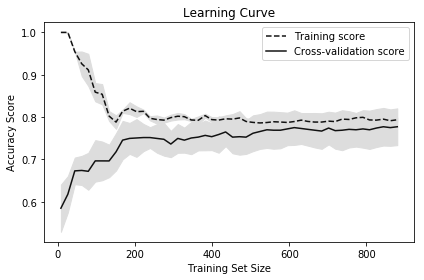

In [24]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [25]:
y_pred = logreg.predict(X_test)

array([[73, 16],
       [27, 80]], dtype=int64)

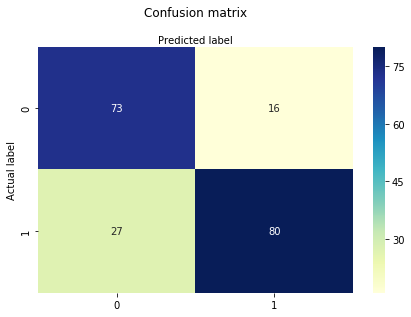

In [26]:
utils.display_confusion_matrix(y_test, y_pred)

In [27]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7806122448979592
Precision: 0.8333333333333334
Recall: 0.7476635514018691
Log loss=  0.4719227897831059


In [28]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.777098674521355


#### Model Feature Optimization

In [29]:
model_stats = eliminate_features_logistic_regression(logreg, X,y)

Iteration=  0
least_important label=  delta_dol
Iteration=  1
least_important label=  delta_wlk
Iteration=  2
least_important label=  delta_off_rating
Iteration=  3
least_important label=  delta_mor
Iteration=  4
least_important label=  delta_rpi
Iteration=  5
least_important label=  delta_pom
Iteration=  6
least_important label=  delta_fg_pct
Iteration=  7
least_important label=  delta_sag
Iteration=  8
least_important label=  delta_col
Iteration=  9
least_important label=  delta_off_rebs_avg
Iteration=  10
least_important label=  delta_to_net_avg
Iteration=  11
least_important label=  delta_ft_att_avg
Iteration=  12
least_important label=  delta_rth
Iteration=  13
least_important label=  delta_sos
Iteration=  14
least_important label=  delta_wol
Iteration=  15
least_important label=  delta_def_rebs_avg
Iteration=  16
least_important label=  delta_seed
Iteration=  17
least_important label=  delta_ft_pct
Iteration=  18
least_important label=  top_conf_t
Iteration=  19
least_important l

In [30]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7092 Cross Val= 0.7771  Log Loss= 0.5452
Accuracy= 0.7092 Cross Val= 0.7751  Log Loss= 0.5444
Accuracy= 0.7092 Cross Val= 0.7792  Log Loss= 0.5449
Accuracy= 0.7092 Cross Val= 0.7802  Log Loss= 0.5450
Accuracy= 0.7092 Cross Val= 0.7802  Log Loss= 0.5457
Accuracy= 0.7092 Cross Val= 0.7802  Log Loss= 0.5446
Accuracy= 0.7092 Cross Val= 0.7832  Log Loss= 0.5429
Accuracy= 0.7092 Cross Val= 0.7822  Log Loss= 0.5426
Accuracy= 0.6888 Cross Val= 0.7822  Log Loss= 0.5396
Accuracy= 0.6939 Cross Val= 0.7801  Log Loss= 0.5343
Accuracy= 0.6939 Cross Val= 0.7812  Log Loss= 0.5340
Accuracy= 0.6837 Cross Val= 0.7761  Log Loss= 0.5327
Accuracy= 0.6888 Cross Val= 0.7812  Log Loss= 0.5335
Accuracy= 0.6888 Cross Val= 0.7628  Log Loss= 0.5827
Accuracy= 0.6888 Cross Val= 0.7659  Log Loss= 0.5830
Accuracy= 0.6786 Cross Val= 0.7649  Log Loss= 0.5853
Accuracy= 0.6786 Cross Val= 0.7710  Log Loss= 0.5876
Accuracy= 0.6939 Cross Val= 0.7629  Log Loss= 0.6004
Accuracy= 0.6939 Cross Val= 0.7629  Log Loss= 

In [31]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg', 'delta_def_rebs_avg', 'delta_ft_pct', 'delta_to_net_avg', 'delta_win_pct', 'delta_ft_att_avg', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wol', 'delta_rth', 'delta_col', 'top_conf_t', 'top_conf_o']


In [32]:
X=X[model_features]

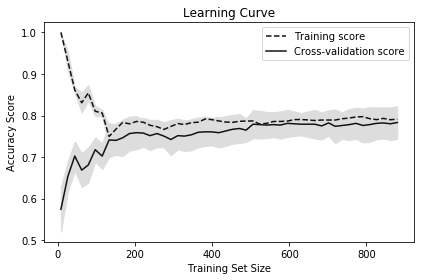

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
logreg.fit(X_train, y_train)


train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [34]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   4.1244791389745945
delta_srs   0.51124368158509
top_conf_o   0.45317045146024404
delta_margin_victory_avg   -0.18024245928102584
top_conf_t   -0.16188949443715855
delta_ft_pct   0.12959946211730114
delta_seed   0.0909643717819619
delta_def_rebs_avg   -0.056049400117131165
delta_sos   0.05455066786804501
delta_wol   -0.05117440803781562
delta_rth   0.04515661599940058
delta_to_net_avg   -0.03326606625823037
delta_ft_att_avg   -0.03146498023930803
delta_off_rebs_avg   0.02896304223980029
delta_sag   0.01980721405798377
delta_col   0.01745428736425328
delta_fg_pct   -0.010003802406587402


[('delta_win_pct', 4.1244791389745945),
 ('delta_srs', 0.51124368158509),
 ('top_conf_o', 0.45317045146024404),
 ('delta_margin_victory_avg', -0.18024245928102584),
 ('top_conf_t', -0.16188949443715855),
 ('delta_ft_pct', 0.12959946211730114),
 ('delta_seed', 0.0909643717819619),
 ('delta_def_rebs_avg', -0.056049400117131165),
 ('delta_sos', 0.05455066786804501),
 ('delta_wol', -0.05117440803781562),
 ('delta_rth', 0.04515661599940058),
 ('delta_to_net_avg', -0.03326606625823037),
 ('delta_ft_att_avg', -0.03146498023930803),
 ('delta_off_rebs_avg', 0.02896304223980029),
 ('delta_sag', 0.01980721405798377),
 ('delta_col', 0.01745428736425328),
 ('delta_fg_pct', -0.010003802406587402)]

Accuracy: 0.7091836734693877
Precision: 0.7232142857142857
Recall: 0.7570093457943925
Log loss=  0.5429184773954154


array([[58, 31],
       [26, 81]], dtype=int64)

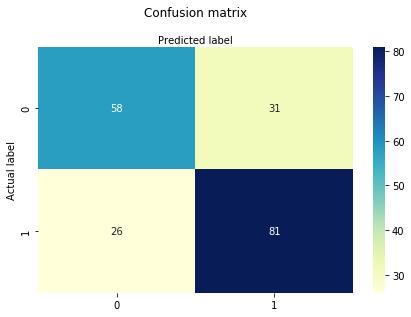

In [35]:
y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)

cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

utils.display_confusion_matrix(y_test, y_pred)

In [36]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print("Cross Validation: ", scores.mean())

Cross Validation:  0.783231643172733


In [38]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, numeric_features, 
                                            prediction_probabilities, X_test, y_test, y_pred)


                                         Duke                     Mercer     Stat Supports Winner
Allow PPG                       67.00                              66.00         True  (L)
Poss Avg                        76.03                              77.71         True  (H)
FG %                            46.00                              47.60         True  (H)
Def Rb Avg                      22.00                              25.00         True  (H)
FT %                            72.90                              73.60         True  (H)
Margin Victory Avg              11.00                              12.00         True  (H)
Win %                           74.30                              75.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              7.00                              89.00        False  (L)
WLK                              8.00                              97.00        Fal

                                       Purdue                    Arizona     Stat Supports Winner
POM                             22.00                              23.00         True  (L)
Allow PPG                       63.00                              72.00         True  (L)
Net Turnover Avg                 6.00                               7.00         True  (L)
Takeaway Avg                     7.00                               6.00         True  (H)
Margin Victory Avg               6.00                               5.00         True  (H)
Win %                           64.70                              64.50         True  (H)
Seed                              9                                  8          False  (L)
SAG                             32.00                              12.00        False  (L)
WLK                             37.00                              15.00        False  (L)
WOL                             48.00                              17.00        Fal

In [39]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
778,2014,64,2014-03-21 00:00:00.0000000,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,78,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,71,-1,2013,Lose,19.51,8.48,0.743,78.0,67.0,0.460,0.729,76.034286,11.0,22.0,9.0,6.0,102.585300,22.0,5.33,-3.42,0.750,78.0,66.0,0.476,0.736,77.705556,11.0,25.0,11.0,5.0,100.378923,21.0,Atlantic Coast,Southern,7,8.0,15,9,14.0,6.0,14.0,9.0,8,89,97.0,90,124,93.0,95.0,100.0,81.0,94,1,0,1,11.0,12.0,-1.000000e+00,-1.600000e-02,9.063045e-18,-3.000000e+00,-7.000000e-03,3.0,6.0,-3.000000e+00,-7.000000e-03,2.206377,1.000000e+00,-1.100000e+01,14.18,11.90,-82.0,-89.0,-75.0,-115.0,-79.0,-89.0,-86.0,-72.0,-86.0,1,0.937884,"[margin_victory_avg, fg_pct, def_rebs_avg, ft_...","[margin_victory_avg, fg_pct, def_rebs_avg, ft_...",21.739130,29.411765,778
852,2016,64,2016-03-18 00:00:00.0000000,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,70,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,56,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.673,85.394286,15.0,23.0,14.0,9.0,91.341006,27.0,9.23,-5.47,0.824,80.0,63.0,0.478,0.735,80.100000,11.0,23.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,0,1,12.0,17.0,-5.000000e+00,-2.900000e-02,4.000000e+00,-1.359457e-17,-6.200000e-02,5.0,3.0,2.000000e+00,-8.100000e-02,-8.534150,7.000000e+00,-1.100000e+01,12.38,15.25,-51.0,-49.0,-54.0,-93.0,-72.0,-27.0,-73.0,-52.0,-25.0,1,0.932984,"[margin_victory_avg, fg_pct, ft_pct, to_net_av...","[margin_victory_avg, fg_pct, ft_pct, to_net_av...",26.086957,29.411765,852
816,2015,32,2015-03-21 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,71,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,68,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,1.100000e+01,3.400000e-02,-2.000000e+00,-1.000000e+00,4.500000e-02,3.0,7.0,-4.000000e+00,3.060000e-01,10.241954,2.000000e+00,-7.000000e+00,9.02,-2.17,-26.0,-29.0,-38.0,-30.0,-38.0,-33.0,-38.0,-37.0,-18.0,1,0.928944,"[off_rebs_avg, def_rebs_avg, sos]","[off_rebs_avg, def_rebs_avg, sos]",13.043478,17.647059,816
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.85,0.767,75.0,65.0,0.476,0.695,79.220000,11.0,25.0,14.0,6.0,94.673062,21.0,2.12,-2.19,0.697,63.0,58.0,0.444,0.701,71.569697,9.0,22.0,15.0,7.0,88.026082,20.0,Big 12,Patriot League,9,7.0,10,7,4.0,12.0,8.0,1.0,19,114,97.0,84,137,102.0,110.0,87.0,64.0,151,1,0,1,10.0,5.0,5.000000e+00,3.200000e-02,2.000000e+00,3.000000e+00,-6.000000e-03,8.0,8.0,-2.492337e-17,7.000000e-02,6.646981,1.000000e+00,-1.100000e+01,18.56,13.04,-105.0,-90.0,-74.0,-130.0,-98.0,-98.0,-79.0,-63.0,-

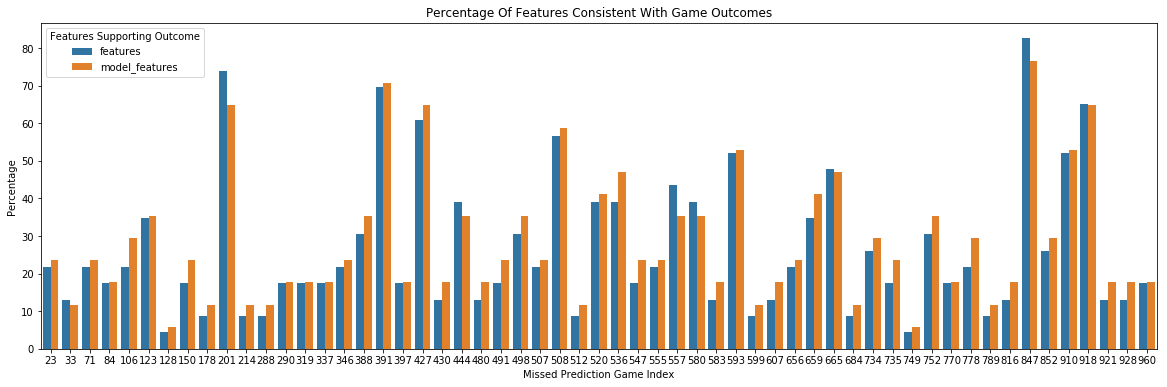

In [40]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [41]:
test_year = 2018

# scale the feature data corresponding to the 2018 tournament
scaler.fit_transform(feature_data[feature_data['season_t'] == test_year][numeric_features])

X_season = feature_data[feature_data['season_t']== test_year][model_features]

y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 17)

array([[24,  9],
       [ 5, 29]], dtype=int64)

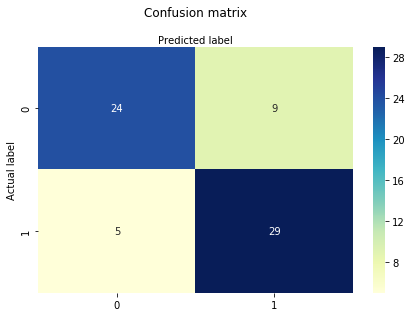

In [42]:
y_pred_season = logreg.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)



In [43]:
prediction_probabilities = logreg.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.7910447761194029
Precision: 0.7631578947368421
Recall: 0.8529411764705882
Log loss=  0.4441737189374534


In [46]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, numeric_features, 
                                            prediction_probabilities,X_season,y_season,y_pred_season)

                               North Carolina                  Texas A&M     Stat Supports Winner
Allow PPG                       73.00                              70.00         True  (L)
FG %                            45.70                              46.00         True  (H)
Def Rb Avg                      28.00                              29.00         True  (H)
FT ATT Avg                      18.00                              19.00         True  (H)
Seed                              2                                  7          False  (L)
SAG                              8.00                              27.00        False  (L)
WLK                              7.00                              28.00        False  (L)
WOL                              8.00                              29.00        False  (L)
RTH                              9.00                              27.00        False  (L)
COL                              9.00                              27.00        Fal

In [47]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
1022,2018,32,2018-03-01 00:00:00.0000000,2,North Carolina,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,86,7,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,65,-1,2017,Lose,20.08,11.78,0.703,81.0,73.0,0.457,0.743,84.670270,13.0,28.0,12.0,5.0,95.665220,18.0,15.30,10.62,0.629,75.0,70.0,0.460,0.661,81.960000,12.0,29.0,13.0,5.0,91.508053,19.0,Atlantic Coast,Southeastern,8,7.0,8,9,9.0,7.0,10.0,4.0,7,27,28.0,29,27,27.0,30.0,28.0,29.0,28,0,0,0,8.0,5.0,17.636573,0.003736,2.169025,-2.391184,0.010899,7.0,8.0,-2.052568,0.011208,32.196353,-4.182197,-37.408996,54.626231,9.566841,-1413.938262,-1453.357150,-1309.059705,-1401.763903,-1132.937795,-1649.863569,-1152.069224,-1418.764999,-1502.399692,1,0.817254,"[fg_pct, def_rebs_avg, ft_att_avg]","[fg_pct, def_rebs_avg, ft_att_avg]",13.043478,17.647059,1022
1038,2018,16,2018-03-01 00:00:00.0000000,2,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,78,3,Texas Tech,f8c705b7-87d3-411a-9c8b-5124daab0469,65,-1,2017,Lose,23.41,8.74,0.811,80.0,65.0,0.493,0.743,75.535135,8.0,26.0,10.0,5.0,105.910978,20.0,19.38,9.60,0.730,74.0,64.0,0.460,0.704,77.816216,10.0,25.0,12.0,7.0,95.095860,22.0,Big Ten,Big 12,5,4.0,9,8,10.0,5.0,5.0,9.0,4,13,13.0,18,14,19.0,12.0,14.0,23.0,10,0,0,0,15.0,10.0,29.473890,0.004937,-5.009692,2.032975,0.008768,5.0,5.0,-0.104478,0.012158,81.896844,-7.856932,-7.923590,46.223900,-5.221065,-598.842033,-626.679717,-564.095950,-472.189958,-569.618151,-506.503578,-578.855508,-796.925116,-434.289038,1,0.756300,"[off_rebs_avg, ft_att_avg, sos]","[off_rebs_avg, ft_att_avg, sos]",13.043478,17.647059,1038
1004,2018,64,2018-03-01 00:00:00.0000000,4,Wichita St,f38b58de-3273-4723-a78b-2f918e9aa2d5,81,13,Marshall,58d8baa3-7624-4b21-a47f-a23df2bf8859,75,-1,2017,Lose,16.58,5.46,0.758,82.0,71.0,0.476,0.739,81.030303,12.0,28.0,11.0,4.0,101.196709,21.0,4.21,0.44,0.694,83.0,79.0,0.467,0.764,83.522222,8.0,27.0,13.0,7.0,99.374751,20.0,American Athletic,Conference USA,15,21.0,14,17,14.0,20.0,20.0,16.0,18,125,102.0,92,110,93.0,114.0,84.0,87.0,118,1,0,1,11.0,4.0,41.311207,0.004136,9.347742,2.032975,0.005597,7.0,6.0,1.843612,0.009850,14.764412,3.167272,-66.894403,139.657823,37.824921,-8157.007062,-5586.744316,-4847.637540,-7211.601059,-4950.993159,-6723.523530,-4081.828220,-4019.186329,-7127.782471,1,0.688938,"[ft_pct, to_net_avg]","[ft_pct, to_net_avg]",8.695652,11.764706,1004
1024,2018,32,2018-03-01 00:00:00.0000000,5,Ohio St,857462b3-0ab6-4d26-9669-10ca354e382b,90,4,Gonzaga,2f4d21f8-6d5f-48a5-abca-52a30583871a,84,-1,2017,Lose,17.67,9.03,0.735,76.0,67.0,0.480,0.731,77.217647,9.0,26.0,11.0,6.0,98.423097,18.0,18.43,2.59,0.865,83.0,67.0,0.498,0.708,80.297297,10.0,28.0,11.0,6.0,103.365870,19.0,Big Ten,West Coast,22,16.0,21,19,18.0,15.0,13.0,20.0,16,10,11.0,10,11,17.0,8.0,12.0,21.0,11,1,0,0,9.0,16.0,-41.550013,0.003235,-2.616786,-4.603263,0.007975,5.0,5.0,-0.104478,-0.016480,-35.733177,-4.182197,6.819113,-7.438989,48.220380,883.151110,337.777289,677.510307,612.312978,56.292564,493.936414,58

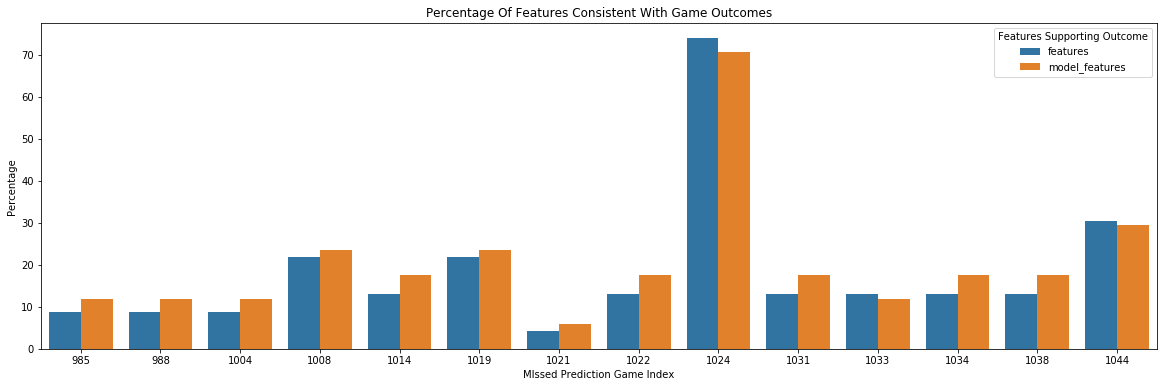

In [48]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('MIssed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)